In [1]:
!pip install keras==2.1.0

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import keras
import os, argparse
import cv2, spacy, numpy as np
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model

In [3]:
model = vgg16.VGG16(weights='imagenet', include_top=True)

W0326 10:58:15.983541 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0326 10:58:15.993305 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:492: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0326 10:58:16.013386 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3630: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0326 10:58:16.043045 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:158: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input

def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [5]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG16(weights='imagenet', include_top=False)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [6]:
vgg_without = get_image_model_without()

W0326 10:59:27.450010 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:711: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0326 10:59:27.455935 140735559299968 deprecation.py:506] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2880: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0326 10:59:27.465766 140735559299968 module_wrapper.py:139] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2884: The name tf.log is deprecated. Please use tf.math.log instead.



In [7]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_core_web_md')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [8]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
model = vgg16.VGG16(weights='imagenet', include_top=True)

In [9]:

def get_image_features_without_fd(image_file_name,model):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape(4096)
    return image_features

In [10]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    with open('our_model_final.json','r') as f:
      vqa_model = keras.models.model_from_json(f.read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [11]:
our_vqa_model = get_VQA_model()
our_vqa_model.summary()

W0326 11:01:52.614692 140735559299968 deprecation.py:506] From /Users/riddhi_11/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3013: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
__________

In [13]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [13]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [14]:
word_embeddings = spacy.load('en_core_web_md')

In [15]:

def get_question_features_without_fd(question,word_embeddings):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [16]:
def create_image_feature_test(image_path,model):
  image_features = get_image_features_without_fd(image_path,model)
  image_feature_processed = np.array(image_features)
  image_feature_processed = image_feature_processed.reshape((1,image_feature_processed.shape[0]))
  return image_feature_processed

In [1]:
new_image = create_image_feature_test('car/7.jpg',model)

NameError: name 'create_image_feature_test' is not defined

In [18]:
new_image2 = create_image_feature_test('sample_data_new/car2.jpg',model)

In [19]:
new_image3 = create_image_feature_test('car/2.jpg',model)

In [20]:
def create_question_feature_test(text):
  question_feature=get_question_features_without_fd(text,word_embeddings)
  question_feature_processed = np.array(question_feature)  
  question_feature_processed = question_feature_processed.reshape((1,question_feature_processed.shape[0], question_feature_processed.shape[1]))
  return question_feature_processed

In [21]:
training_datas = []
with open('car/new_training.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for row in csv_reader:
    print (row)
    training_datas.append(row)
training_datas = training_datas[1:]
len(training_datas)

['\ufeffImageid', 'Question', 'Answer']
['1', 'is this a car', 'yes']
['2', 'is this a car', 'yes']
['3', 'is this a car', 'yes']
['4', 'is this a car', 'yes']
['5', 'is this a car', 'yes']
['6', 'is this a car', 'yes']
['7', 'is this a car', 'yes']
['8', 'is this a car', 'yes']
['9', 'is this a car', 'yes']
['10', 'is this a car', 'yes']
['11', 'is this a car', 'yes']
['12', 'is this a car', 'yes']
['13', 'is this a car', 'yes']
['14', 'is this a car', 'yes']
['15', 'is this a car', 'yes']
['16', 'is this a car', 'yes']
['17', 'is this a car', 'yes']
['18', 'is this a car', 'yes']
['19', 'is this a car', 'yes']
['20', 'is this a car', 'yes']
['21', 'is this a car', 'yes']
['22', 'is this a car', 'yes']
['23', 'is this a car', 'yes']
['24', 'is this a car', 'yes']
['25', 'is this a car', 'yes']
['26', 'is this a car', 'yes']
['27', 'is this a car', 'yes']
['28', 'is this a car', 'yes']
['29', 'is this a car', 'yes']
['30', 'is this a car', 'yes']
['31', 'is this a car', 'yes']
['32', '

['578', 'what is this ', 'car']
['579', 'what is this ', 'car']
['580', 'what is this ', 'car']
['581', 'what is this ', 'car']
['582', 'what is this ', 'car']
['583', 'what is this ', 'car']
['584', 'what is this ', 'car']
['585', 'what is this ', 'car']
['586', 'what is this ', 'car']
['587', 'what is this ', 'car']
['588', 'what is this ', 'car']
['589', 'what is this ', 'car']
['590', 'what is this ', 'car']
['591', 'what is this ', 'car']
['592', 'what is this ', 'car']
['593', 'what is this ', 'car']
['594', 'what is this ', 'car']
['595', 'what is this ', 'car']
['596', 'what is this ', 'car']
['597', 'what is this ', 'car']
['598', 'what is this ', 'car']
['599', 'what is this ', 'car']
['600', 'what is this ', 'car']
['601', 'what is this ', 'car']
['602', 'what is this ', 'car']
['603', 'what is this ', 'car']
['604', 'what is this ', 'car']
['605', 'what is this ', 'car']
['606', 'what is this ', 'car']
['607', 'what is this ', 'car']
['608', 'what is this ', 'car']
['609', 

2957

In [22]:
trainY= []
image_ids = []
for training_data in training_datas:
    img_id,text,output = training_data
    trainY.append(output)
    image_ids.append(img_id)
image_ids_set = list(set(image_ids))
print(len(trainY))
print(trainY)

2957
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 

In [23]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

In [24]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=22)

In [25]:
trainX= []
for training_data in training_datas:
  img_id,text,output = training_data
  print("Processing {} image".format(img_id))
  image_features = get_image_features_without_fd("car/{}.jpg".format(img_id),model)
  question_features = get_question_features_without_fd(text,word_embeddings)
  trainX.append([question_features,image_features])
np.array(trainX).shape

Processing 1 image
Processing 2 image
Processing 3 image
Processing 4 image
Processing 5 image
Processing 6 image
Processing 7 image
Processing 8 image
Processing 9 image
Processing 10 image
Processing 11 image
Processing 12 image
Processing 13 image
Processing 14 image
Processing 15 image
Processing 16 image
Processing 17 image
Processing 18 image
Processing 19 image
Processing 20 image
Processing 21 image
Processing 22 image
Processing 23 image
Processing 24 image
Processing 25 image
Processing 26 image
Processing 27 image
Processing 28 image
Processing 29 image
Processing 30 image
Processing 31 image
Processing 32 image
Processing 33 image
Processing 34 image
Processing 35 image
Processing 36 image
Processing 37 image
Processing 38 image
Processing 39 image
Processing 40 image
Processing 41 image
Processing 42 image
Processing 43 image
Processing 44 image
Processing 45 image
Processing 46 image
Processing 47 image
Processing 48 image
Processing 49 image
Processing 50 image
Processin

Processing 397 image
Processing 398 image
Processing 399 image
Processing 400 image
Processing 401 image
Processing 402 image
Processing 403 image
Processing 404 image
Processing 405 image
Processing 406 image
Processing 407 image
Processing 408 image
Processing 409 image
Processing 410 image
Processing 411 image
Processing 412 image
Processing 413 image
Processing 414 image
Processing 415 image
Processing 416 image
Processing 417 image
Processing 418 image
Processing 419 image
Processing 420 image
Processing 421 image
Processing 422 image
Processing 423 image
Processing 424 image
Processing 425 image
Processing 426 image
Processing 427 image
Processing 428 image
Processing 429 image
Processing 430 image
Processing 431 image
Processing 432 image
Processing 433 image
Processing 434 image
Processing 435 image
Processing 436 image
Processing 437 image
Processing 438 image
Processing 439 image
Processing 440 image
Processing 441 image
Processing 442 image
Processing 443 image
Processing 44

Processing 788 image
Processing 789 image
Processing 790 image
Processing 791 image
Processing 792 image
Processing 793 image
Processing 794 image
Processing 795 image
Processing 796 image
Processing 797 image
Processing 798 image
Processing 799 image
Processing 800 image
Processing 801 image
Processing 802 image
Processing 803 image
Processing 804 image
Processing 805 image
Processing 806 image
Processing 807 image
Processing 808 image
Processing 809 image
Processing 810 image
Processing 811 image
Processing 812 image
Processing 813 image
Processing 814 image
Processing 815 image
Processing 816 image
Processing 817 image
Processing 818 image
Processing 819 image
Processing 820 image
Processing 821 image
Processing 822 image
Processing 823 image
Processing 824 image
Processing 825 image
Processing 826 image
Processing 827 image
Processing 828 image
Processing 829 image
Processing 830 image
Processing 831 image
Processing 832 image
Processing 833 image
Processing 834 image
Processing 83

Processing 29 image
Processing 30 image
Processing 31 image
Processing 32 image
Processing 33 image
Processing 34 image
Processing 35 image
Processing 36 image
Processing 37 image
Processing 38 image
Processing 39 image
Processing 40 image
Processing 41 image
Processing 42 image
Processing 43 image
Processing 44 image
Processing 45 image
Processing 46 image
Processing 47 image
Processing 48 image
Processing 49 image
Processing 50 image
Processing 51 image
Processing 52 image
Processing 53 image
Processing 54 image
Processing 55 image
Processing 56 image
Processing 57 image
Processing 58 image
Processing 59 image
Processing 60 image
Processing 61 image
Processing 62 image
Processing 63 image
Processing 64 image
Processing 65 image
Processing 66 image
Processing 67 image
Processing 68 image
Processing 69 image
Processing 70 image
Processing 71 image
Processing 72 image
Processing 73 image
Processing 74 image
Processing 75 image
Processing 76 image
Processing 77 image
Processing 78 image


Processing 423 image
Processing 424 image
Processing 425 image
Processing 426 image
Processing 427 image
Processing 428 image
Processing 429 image
Processing 430 image
Processing 431 image
Processing 432 image
Processing 433 image
Processing 434 image
Processing 435 image
Processing 436 image
Processing 437 image
Processing 438 image
Processing 439 image
Processing 440 image
Processing 441 image
Processing 442 image
Processing 443 image
Processing 444 image
Processing 445 image
Processing 446 image
Processing 447 image
Processing 448 image
Processing 449 image
Processing 450 image
Processing 451 image
Processing 452 image
Processing 453 image
Processing 454 image
Processing 455 image
Processing 456 image
Processing 457 image
Processing 458 image
Processing 459 image
Processing 460 image
Processing 461 image
Processing 462 image
Processing 463 image
Processing 464 image
Processing 465 image
Processing 466 image
Processing 467 image
Processing 468 image
Processing 469 image
Processing 47

Processing 814 image
Processing 815 image
Processing 816 image
Processing 817 image
Processing 818 image
Processing 819 image
Processing 820 image
Processing 821 image
Processing 822 image
Processing 823 image
Processing 824 image
Processing 825 image
Processing 826 image
Processing 827 image
Processing 828 image
Processing 829 image
Processing 830 image
Processing 831 image
Processing 832 image
Processing 833 image
Processing 834 image
Processing 835 image
Processing 836 image
Processing 837 image
Processing 838 image
Processing 839 image
Processing 840 image
Processing 841 image
Processing 842 image
Processing 843 image
Processing 844 image
Processing 845 image
Processing 846 image
Processing 847 image
Processing 848 image
Processing 849 image
Processing 850 image
Processing 851 image
Processing 852 image
Processing 853 image
Processing 854 image
Processing 855 image
Processing 856 image
Processing 857 image
Processing 858 image
Processing 859 image
Processing 860 image
Processing 86

Processing 242 image
Processing 243 image
Processing 244 image
Processing 245 image
Processing 246 image
Processing 247 image
Processing 248 image
Processing 249 image
Processing 250 image
Processing 251 image
Processing 252 image
Processing 253 image
Processing 254 image
Processing 255 image
Processing 256 image
Processing 257 image
Processing 258 image
Processing 259 image
Processing 260 image
Processing 261 image
Processing 262 image
Processing 263 image
Processing 264 image
Processing 265 image
Processing 266 image
Processing 267 image
Processing 268 image
Processing 269 image
Processing 270 image
Processing 271 image
Processing 272 image
Processing 273 image
Processing 274 image
Processing 275 image
Processing 276 image
Processing 277 image
Processing 278 image
Processing 279 image
Processing 280 image
Processing 281 image
Processing 282 image
Processing 283 image
Processing 284 image
Processing 285 image
Processing 286 image
Processing 287 image
Processing 288 image
Processing 28

Processing 633 image
Processing 634 image
Processing 635 image
Processing 636 image
Processing 637 image
Processing 638 image
Processing 639 image
Processing 640 image
Processing 641 image
Processing 642 image
Processing 643 image
Processing 644 image
Processing 645 image
Processing 646 image
Processing 647 image
Processing 648 image
Processing 649 image
Processing 650 image
Processing 651 image
Processing 652 image
Processing 653 image
Processing 654 image
Processing 655 image
Processing 656 image
Processing 657 image
Processing 658 image
Processing 659 image
Processing 660 image
Processing 661 image
Processing 662 image
Processing 663 image
Processing 664 image
Processing 665 image
Processing 666 image
Processing 667 image
Processing 668 image
Processing 669 image
Processing 670 image
Processing 671 image
Processing 672 image
Processing 673 image
Processing 674 image
Processing 675 image
Processing 676 image
Processing 677 image
Processing 678 image
Processing 679 image
Processing 68

(2957, 2)

In [26]:
question_features_array = []
image_features_array = []
for x in trainX:
  question_features_array.append(x[0])
  image_features_array.append(x[1])

In [27]:
question_features_array = np.array(question_features_array)
image_features_array = np.array(image_features_array)
print(question_features_array.shape)
print(image_features_array.shape)

(2957, 30, 300)
(2957, 4096)


In [28]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

2957
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 

In [29]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

In [30]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=22)

In [ ]:
history = our_vqa_model.fit([question_features_array,image_features_array],trainY_cate,5,5)

Epoch 1/5
2957/2957 [==============================] - 495s 167ms/step - loss: 2.4068
Epoch 2/5
2957/2957 [==============================] - 494s 167ms/step - loss: 2.2892
Epoch 3/5
2957/2957 [==============================] - 495s 167ms/step - loss: 2.2137
Epoch 4/5
2957/2957 [==============================] - 495s 167ms/step - loss: 2.1672
Epoch 5/5
2930/2957 [============================>.] - ETA: 4s - loss: 2.1775

In [31]:
filename = 'model_weights_after_training_jupyter_car.h5'
outfile = open(filename,'wb')
our_vqa_model.save_weights(filename)

In [32]:
# Save the model architecture
model_arch = 'model_architecture_after_training_jupyter_car.json'
outfile = open(model_arch,'wb')
with open(model_arch, 'w') as f:
    f.write(our_vqa_model.to_json())
    

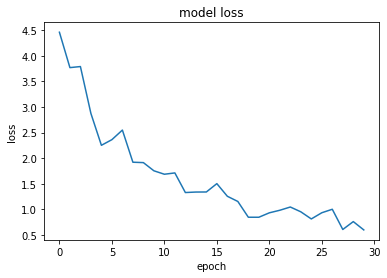

In [33]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# LOAD the model architecture
model_arch_read = 'model_architecture_after_training_jupyter_car.json'

with open(model_arch_read, 'r') as f:
    vqa_model = model_from_json(f.read())

# Load weights into the new model
vqa_model.load_weights(filename);

In [41]:
new_question = create_question_feature_test("is this a car")

In [43]:
new_image = create_image_feature_test('car/37.jpg',model)

In [44]:
print(vqa_model.predict_classes([new_question,new_image]))

1/1 [==============================] - 0s 116ms/step
[2]


In [45]:
result=set_trainy[vqa_model.predict_classes([new_question,new_image])[0]]
print(set_trainy)

1/1 [==============================] - 0s 67ms/step
['red', 'bike', 'apple', 'dog', 'white', 'yes', 'jeep', 'black', 'female', 'hibiscus', 'pear', 'leg', 'orange', 'rose', 'no', '2', 'banana', 'lemon', 'green', 'yellow', 'fruit', 'car']


In [46]:
print(result)

apple
